# 1. 数据获取

通过sklearn提供的方法来获取数据，并拆分出训练集和测试集。为避免header等元数据对训练造成干扰， 直接去除。

In [1]:
from sklearn.datasets import fetch_20newsgroups

#newsgroups_all = fetch_20newsgroups(data_home='.', subset='all', remove=('footers', 'quotes'))

#newsgroups_train = fetch_20newsgroups(data_home='.', subset='train', remove=('headers', 'footers', 'quotes'))
#newsgroups_test = fetch_20newsgroups(data_home='.', subset='test', remove=('headers', 'footers', 'quotes'))

newsgroups_train = fetch_20newsgroups(data_home='.', subset='train', remove=('footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(data_home='.', subset='test', remove=('footers', 'quotes'))

newsgroups_target_names = newsgroups_train.target_names

In [2]:
# 查看类别名称
from pprint import pprint
pprint(newsgroups_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [3]:
# 检查数据内容
print(newsgroups_train.target_names[newsgroups_train.target[0]])
print(newsgroups_train.data[0])

rec.autos
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


## 1.1 数据分割

In [4]:
from sklearn.model_selection import train_test_split

# 先划分训练集和测试集
X_train, y_train = newsgroups_train.data, newsgroups_train.target
X_test, y_test = newsgroups_test.data, newsgroups_test.target

# 训练集进一步划分为训练集和验证集
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

#X_train, X_test, y_train, y_test = train_test_split(newsgroups_all.data, newsgroups_all.target, test_size=0.2, random_state=0, stratify=newsgroups_all.target)
#X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [5]:
print('train size: {}'.format(len(X_train)))
print('train sub size: {}'.format(len(X_train_sub)))
print('val size: {}'.format(len(X_val)))
print('test size: {}'.format(len(X_test)))

train size: 11314
train sub size: 9051
val size: 2263
test size: 7532


# 2. 数据探索

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

首先检查训练集、验证集和测试集类别分布情况，看数据在类别上的分布是否有倾斜。

In [7]:
def label_distributation(data, title):
    label_dist = data['catid'].value_counts().sort_index().rename(dict([(i, cid) for i, cid in enumerate(newsgroups_target_names)]))
    label_dist.plot.bar(title=title, figsize=(10,5))

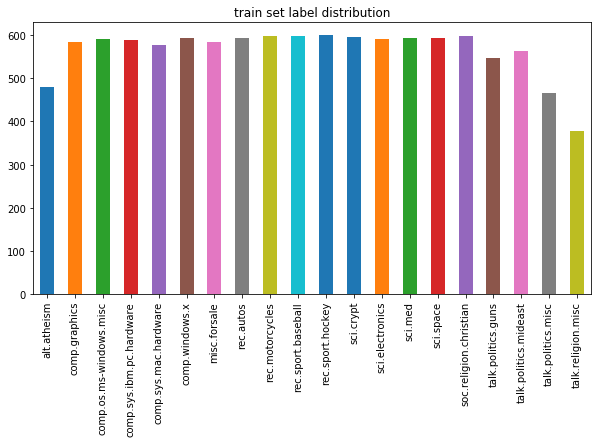

In [8]:
label_distributation(pd.DataFrame(data={'catid': y_train}), 'train set label distribution')

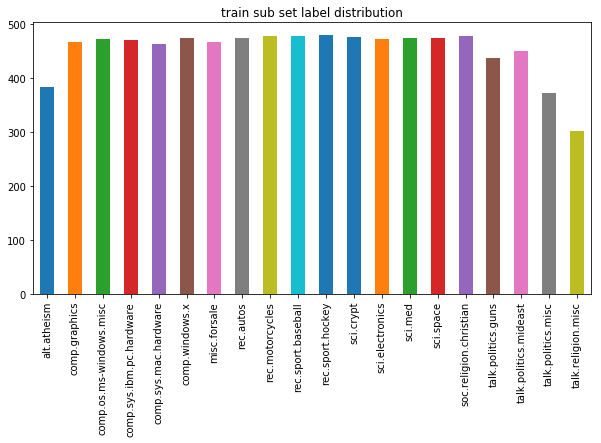

In [9]:
label_distributation(pd.DataFrame(data={'catid': y_train_sub}), 'train sub set label distribution')

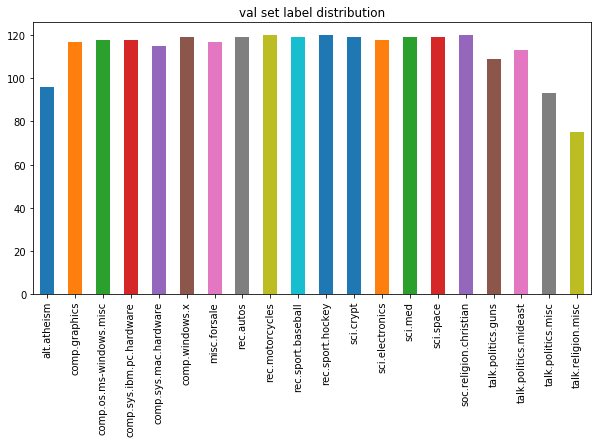

In [10]:
label_distributation(pd.DataFrame(data={'catid': y_val}), 'val set label distribution')

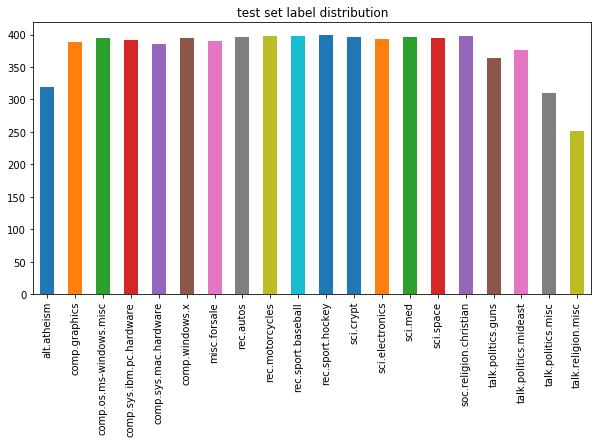

In [14]:
label_distributation(pd.DataFrame(data={'catid': y_test}), 'test set label distribution')

从上面三张图可以看到，训练集、验证集和测试集的数据在各个类别的分布比较均匀，只有一个类别`talk.religion.misc`数据量略小，但预计不会对模型的训练有太大影响。

# 3. 特征提取

## 3.1 BoW特征

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english', min_df=5, max_df=0.9)

count_vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
print('vocabulary size: {}'.format(len(count_vect.vocabulary_)))
print('stop word size: {}'.format(len(count_vect.stop_words_)))

#tokenizer = count_vect.build_tokenizer()

vocabulary size: 19559
stop word size: 79369


## 3.2 TFIDF特征

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(count_vect.transform(X_train))

X_train_sub_tfidf = tfidf_transformer.transform(count_vect.transform(X_train_sub))
X_val_tfidf = tfidf_transformer.transform(count_vect.transform(X_val))

## 3.3 词向量word2vec

In [15]:
import os
from gensim.models import word2vec

if not os.path.isfile('./text8.model'):
    sentences = word2vec.Text8Corpus('./text8')
    model_text8 = word2vec.Word2Vec(sentences, sg=0, size=256)
    model_text8.save('./text8.model')
    print('word2vec model trained and saved')
else:
    model_text8 = word2vec.Word2Vec.load('./text8.model')
    print('word2vec model loaded from disk')

D:\install\Anaconda3\envs\mlnd_capstone\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


word2vec model trained and saved


In [16]:
print(model_text8.wv['the'])
print(type(model_text8.wv['the']))
print(model_text8.wv['the'].shape)
print(dir(model_text8.wv))

[ 0.07830499  0.4838841  -0.0714353   0.11215177 -1.13926196 -0.41406572
  0.59025079  0.31925032  0.11313295  0.66538143 -0.01984603  0.07348106
 -0.03422415  1.29164791  0.83218837 -0.25025764 -0.05243709 -0.89039898
 -0.20876864 -0.43017021 -0.35880628 -0.77961355 -0.19368224  0.91573316
  0.51635551  0.1730556  -0.50239265 -0.25855511 -0.8993119  -0.65576053
 -1.22423685  0.93842435  0.4490414   0.84233862  1.87786889 -0.57461399
  0.31411368  0.07212567  0.08989782 -0.03851745 -0.0155832   0.12756068
 -0.07317996  0.27903271  0.19389807 -1.06848443  1.06241083 -0.15498795
 -0.15648779 -0.13618696 -0.90907592 -0.01361875 -1.35213137 -0.47370857
  0.68189555  0.01026469 -0.01478412  0.2011219   0.00571566  0.28632823
 -0.42103043  0.18227752  0.43006787 -0.81824571  0.90517646  1.17463434
 -0.56730849  1.12593389  0.14773802  0.8136856  -0.66097265 -0.91375029
 -0.20170189 -0.16357583  1.52358532  0.65064561 -0.34107244 -0.86468333
  0.03543699  0.64334476  0.56867391 -0.25500119  1

# 4. 模型

In [17]:
from sklearn.metrics import fbeta_score, accuracy_score
from time import time
from sklearn.model_selection import GridSearchCV

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    results = {}
    start = time()
    
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
    
    start = time()
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train)
    end = time()
    results['pred_time'] = end - start
    
    results['name'] = learner.__class__.__name__
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_val'] = accuracy_score(y_val, predictions_val)

    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    return results

## A. TFIDF+决策树

In [23]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

pprint(train_predict(tree, X_train_sub_tfidf.shape[0], X_train_sub_tfidf, y_train_sub, X_val_tfidf, y_val))

DecisionTreeClassifier trained on 9051 samples.
{'acc_train': 1.0,
 'acc_val': 0.59699513919575786,
 'name': 'DecisionTreeClassifier',
 'pred_time': 0.015626907348632812,
 'train_time': 8.921345949172974}


In [24]:
parameters = {'max_depth': [10, 100, 200, 500], 'min_samples_leaf': [2, 5, 10]}
grid_obj = GridSearchCV(DecisionTreeClassifier(), parameters)

grid_obj.fit(X_train_tfidf, y_train)

print('best params: {}'.format(grid_obj.best_params_))
print('best score: {}'.format(grid_obj.best_score_))

best params: {'max_depth': 500, 'min_samples_leaf': 2}
best score: 0.5800777797419127


## B. TFIDF+朴素贝叶斯

In [18]:
from sklearn.naive_bayes import MultinomialNB

In [19]:
mnb = MultinomialNB(alpha=.1)
pprint(train_predict(mnb, X_train_sub_tfidf.shape[0], X_train_sub_tfidf, y_train_sub, X_val_tfidf, y_val))

MultinomialNB trained on 9051 samples.
{'acc_train': 0.97746105402717931,
 'acc_val': 0.85108263367211667,
 'name': 'MultinomialNB',
 'pred_time': 0.020588397979736328,
 'train_time': 0.04008936882019043}


In [20]:
parameters = {'alpha': [.001, .01, .02, .03, .04, .05, .06, .1, .3]}
grid_obj = GridSearchCV(MultinomialNB(), parameters)

grid_obj.fit(X_train_tfidf, y_train)

print('best params: {}'.format(grid_obj.best_params_))
print('best score: {}'.format(grid_obj.best_score_))

best params: {'alpha': 0.04}
best score: 0.8499204525366802


In [21]:
X_test_tfidf = tfidf_transformer.transform(count_vect.transform(X_test))
print('Test set acc: {}'.format(grid_obj.best_estimator_.score(X_test_tfidf, y_test)))

Test set acc: 0.7846521508231545


In [ ]:
from sklearn import metrics

predicted = mnb.predict(X_val_tfidf)
print(metrics.classification_report(y_val, predicted, target_names=newsgroups_all.target_names))

In [ ]:
metrics.confusion_matrix(y_val, predicted)

## C. TFIDF+SVM

In [25]:
from sklearn.svm import SVC

In [21]:
svm = SVC(C=.1, kernel='linear')
pprint(train_predict(svm, X_train_sub_tfidf.shape[0], X_train_sub_tfidf, y_train_sub, X_val_tfidf, y_val))

SVC trained on 12060 samples.
{'acc_train': 0.62114427860696519,
 'acc_val': 0.54210875331564989,
 'name': 'SVC',
 'pred_time': 90.80419373512268,
 'train_time': 115.71861863136292}


In [52]:
#parameters = {'C': [.1, .3, .5, .8], 'kernel': ['linear', 'poly']}
parameters = {'C': [.1, .3, .5, .8], 'kernel': ['linear']}
grid_obj = GridSearchCV(SVC(), parameters)

grid_obj.fit(X_train_tfidf, y_train)

print('best params: {}'.format(grid_obj.best_params_))
print('best score: {}'.format(grid_obj.best_score_))

best params: {'C': 0.8, 'kernel': 'linear'}
best score: 0.7211419480289907


## D. Word2Vec+CNN

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import regularizers

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 256

Using TensorFlow backend.


In [27]:
print('Processing text dataset')

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


X_train_dl = pad_sequences(tokenizer.texts_to_sequences(X_train_sub), maxlen=MAX_SEQUENCE_LENGTH)
y_train_dl = to_categorical(np.asarray(y_train_sub), num_classes=20)

X_val_dl = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SEQUENCE_LENGTH)
y_val_dl = to_categorical(np.asarray(y_val), num_classes=20)

print('Shape of train data tensor:', X_train_dl.shape)
print('Shape of train label tensor:', y_train_dl.shape)


Processing text dataset
Found 102221 unique tokens.
Shape of train data tensor: (9051, 1000)
Shape of train label tensor: (9051, 20)


In [28]:
print('Preparing embedding matrix.')

num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in model_text8.wv:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model_text8.wv[word]


Preparing embedding matrix.


In [29]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


In [36]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(len(newsgroups_target_names), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(X_train_dl, y_train_dl,
          batch_size=128,
          epochs=80,
          validation_data=(X_val_dl, y_val_dl))

Training model.
Train on 9051 samples, validate on 2263 samples
Epoch 1/80
9051/9051 [==============================] - 5s 589us/step - loss: 5.0210 - acc: 0.0853 - val_loss: 3.4662 - val_acc: 0.1189
Epoch 2/80
9051/9051 [==============================] - 5s 530us/step - loss: 3.0109 - acc: 0.1621 - val_loss: 2.6993 - val_acc: 0.1922
Epoch 3/80
9051/9051 [==============================] - 5s 530us/step - loss: 2.5579 - acc: 0.2167 - val_loss: 2.2801 - val_acc: 0.3252
Epoch 4/80
9051/9051 [==============================] - 5s 534us/step - loss: 2.3342 - acc: 0.2738 - val_loss: 2.2346 - val_acc: 0.3217
Epoch 5/80
9051/9051 [==============================] - 5s 531us/step - loss: 2.1656 - acc: 0.3402 - val_loss: 2.4240 - val_acc: 0.2894
Epoch 6/80
9051/9051 [==============================] - 5s 531us/step - loss: 2.0432 - acc: 0.3892 - val_loss: 2.2712 - val_acc: 0.3354
Epoch 7/80
9051/9051 [==============================] - 5s 531us/step - loss: 1.9159 - acc: 0.4467 - val_loss: 1.7603 - 

9051/9051 [==============================] - 5s 537us/step - loss: 0.8933 - acc: 0.8882 - val_loss: 2.1853 - val_acc: 0.6222
Epoch 61/80
9051/9051 [==============================] - 5s 536us/step - loss: 0.8916 - acc: 0.8862 - val_loss: 2.1472 - val_acc: 0.6231
Epoch 62/80
9051/9051 [==============================] - 5s 535us/step - loss: 0.8894 - acc: 0.8840 - val_loss: 1.9696 - val_acc: 0.6531
Epoch 63/80
9051/9051 [==============================] - 5s 537us/step - loss: 0.8910 - acc: 0.8894 - val_loss: 1.7593 - val_acc: 0.6880
Epoch 64/80
9051/9051 [==============================] - 5s 537us/step - loss: 0.8777 - acc: 0.8947 - val_loss: 1.9111 - val_acc: 0.6770
Epoch 65/80
9051/9051 [==============================] - 5s 537us/step - loss: 0.8565 - acc: 0.8938 - val_loss: 2.0752 - val_acc: 0.6438
Epoch 66/80
9051/9051 [==============================] - 5s 536us/step - loss: 0.8965 - acc: 0.8812 - val_loss: 1.9515 - val_acc: 0.6571
Epoch 67/80
9051/9051 [==============================

In [37]:
X_test_dl = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)
y_test_dl = to_categorical(np.asarray(y_test), num_classes=20)

score = model.evaluate(X_test_dl, y_test_dl, batch_size=128)

7532/7532 [==============================] - 1s 172us/step


In [38]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[3.0164064435457463, 0.5180562932125381]
